In [9]:
#hihihi
!pip install nibabel

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.signal import convolve

test_load = nib.load('./armotor_2894.nii')
print(test_load.header)
print(type(test_load))
print(test_load)#data shape (128, 128, 33, 90)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 128 128  33  90   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.8749993  1.8749999  5.000005   3.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'spm - realigned acq-fix ref-slice 1'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0

In [4]:
tr = 3
conditions = ["c0", "c0"]
duration = [60, 60]
onsets = [90.0, 210.0]

<class 'numpy.memmap'>
(128, 128, 33, 90)


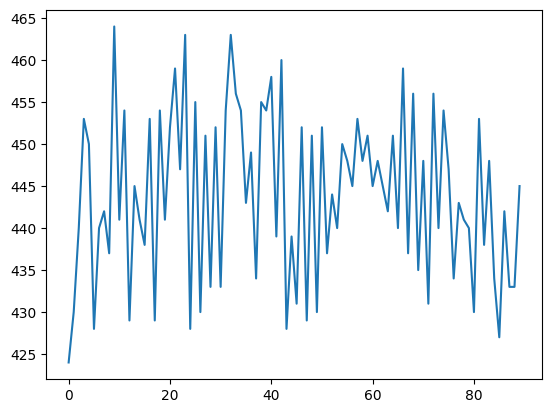

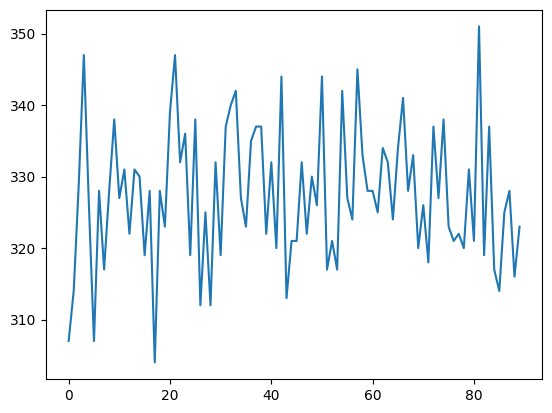

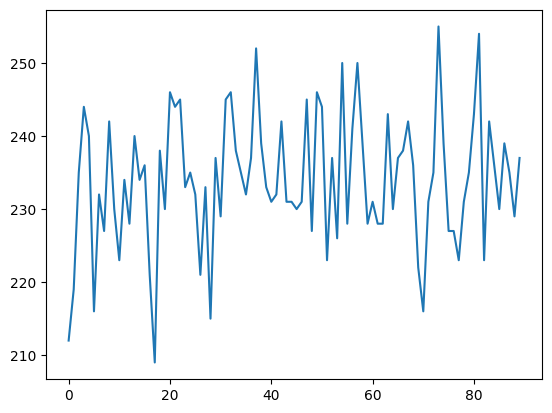

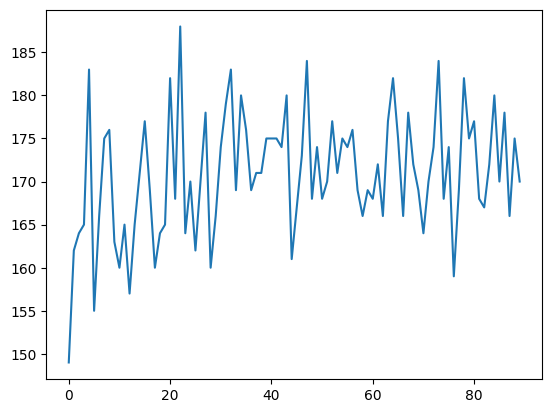

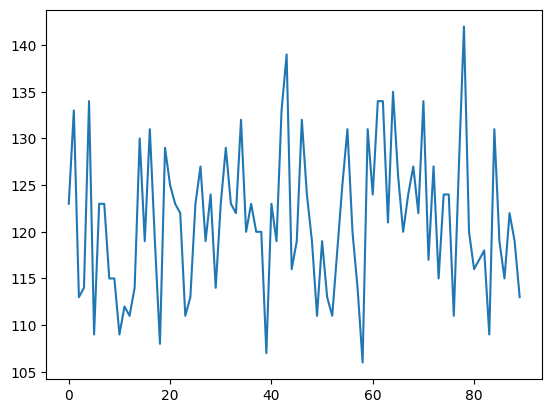

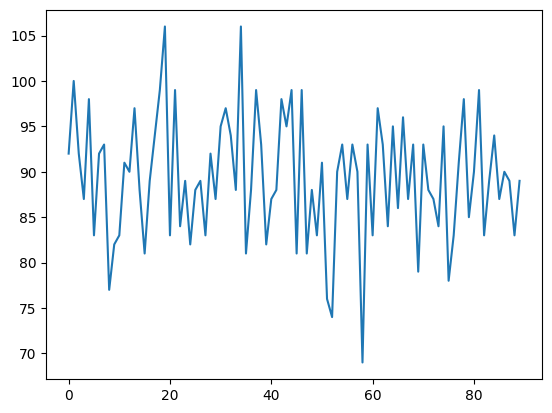

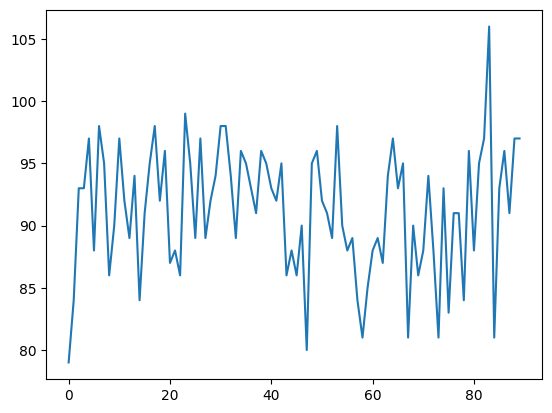

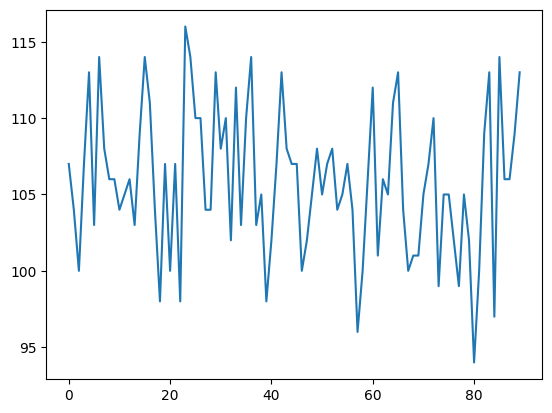

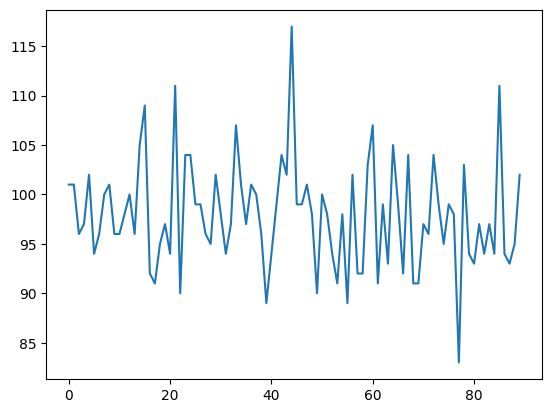

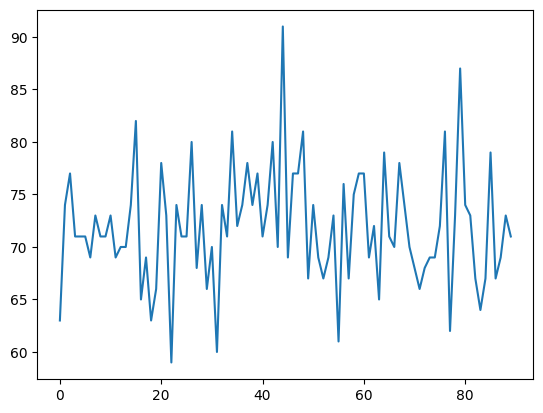

In [13]:
raw_data = test_load.get_fdata()
print(type(raw_data))
print(raw_data.shape)
#z축은 0이 바닥 33이 옥상
#y축은 0이 뒤쪽 128이 앞쪽(눈방향)
#x축은 0이 왼쪽눈 128이 오른쪽눈 마주보는 사람 기준 아님. 찍히는 사람 기준임
for i in range(10):
    plt.plot(raw_data[70,60+i,9,:])
    plt.show()
    #이 그래프에선 onset이 30, 70

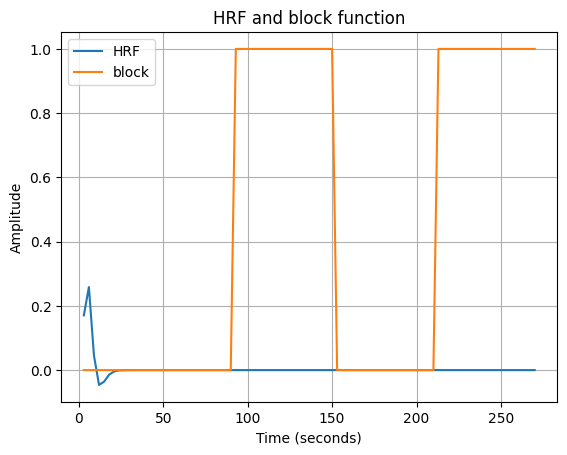

In [10]:
# HRF 함수를 정의합니다.
def hrf(t):
    # Gamma pdf for the peak
    peak_values = gamma.pdf(t, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(t, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to random value between 0.01 and 0.1
    random_value = np.random.uniform(0.2, 0.6)
    return values / np.max(values) *random_value

def block_function(time, onsets, durations):
    """Create a block function with value 1 at specified delta locations."""
    block = np.zeros_like(time)
    block_duration = np.zeros_like(durations)
    interval = time[1] - time[0]
    for index, duration in enumerate(durations):
        block_duration[index] = int(duration/interval)
    for index, loc in enumerate(onsets):
        start = int(loc/interval)
        block[start:start+block_duration[index]] = 1
    return block

# 시간 범위 설정 (예: 0부터 290초까지)
time = np.linspace(3, 270, 90)

# onsets에 해당하는 지점에 60초 동안 지속되는 블록 함수 생성
onsets = [90, 210]
durations = [60, 60]
hrf_values = hrf(time)
block_values = block_function(time, onsets, durations)


# 그래프 그리기
plt.plot(time, hrf_values, label="HRF")
plt.plot(time, block_values, label="block")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("HRF and block function")
plt.grid(True)
plt.legend()
plt.show()


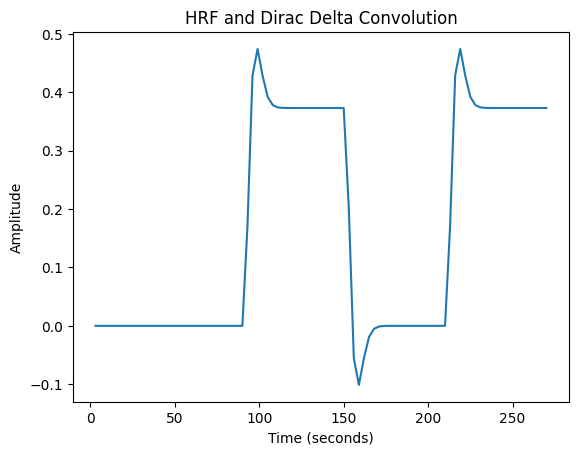

In [11]:
# 컨볼루션을 수행합니다.
synthetic_fMRI_signal = convolve(hrf_values, block_values, mode='full')[:len(time)]
# 결과를 플롯합니다.
plt.plot(time, synthetic_fMRI_signal)
plt.title('HRF and Dirac Delta Convolution')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

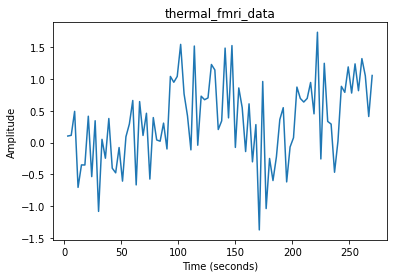

In [34]:
# 열 잡음의 표준 편차를 설정합니다.
noise_std = 0.5  # 잡음의 표준 편차

# 정규 분포를 따르는 열 잡음을 생성합니다.
thermal_noise = np.random.normal(0, noise_std, synthetic_fMRI_signal.shape)

# 원본 데이터에 열 잡음을 주입합니다.
thermal_fmri_data = synthetic_fMRI_signal + thermal_noise

plt.plot(time, thermal_fmri_data)
plt.title('thermal_fmri_data')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

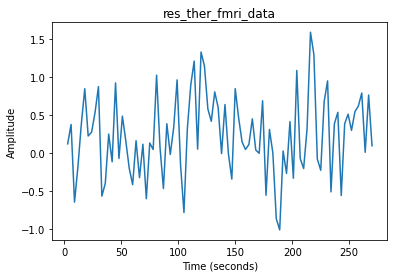

In [21]:
# 호흡 잡음의 특성을 설정합니다.
resp_rate = 15  # 분당 호흡
sampling_rate = 0.5  # 데이터 샘플링 레이트 (Hz)
duration = 270 / sampling_rate

resp_t = np.linspace(3, duration, 90)
resp_frequency = resp_rate / 60  # 호흡 주파수 (Hz)
resp_noise = np.sin(2 * np.pi * resp_frequency * resp_t)

scaling_factor = 0.1

# 원본 데이터에 호흡 잡음을 주입합니다.
res_ther_fmri_data = thermal_fmri_data + resp_noise * scaling_factor

plt.plot(time, res_ther_fmri_data)
plt.title('res_ther_fmri_data')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

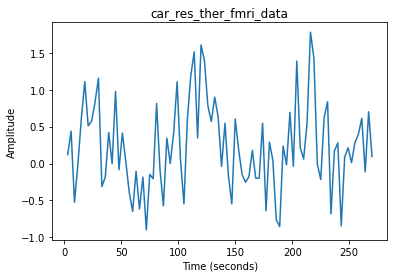

In [35]:
# 심장 박동 잡음의 특성을 설정합니다.
heart_rate = 60  # 분당 심장 박동수
sampling_rate = 0.5  # 데이터 샘플링 레이트 (Hz)
duration = 270 / sampling_rate


# 심장 박동 잡음을 생성합니다.  정현파를 사용합니다.
cardiac_t = np.linspace(3, duration, 90)
cardiac_frequency = heart_rate / 60  # 심장 박동 주파수 (Hz)
cardiac_noise = np.sin(2 * np.pi * cardiac_frequency * cardiac_t)

scaling_factor = 0.3  # 잡음의 크기를 조절하는 스케일링 팩터
car_res_ther_fmri_data = res_ther_fmri_data + scaling_factor * cardiac_noise

plt.plot(time, car_res_ther_fmri_data)
plt.title('car_res_ther_fmri_data')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [36]:
import torch.nn as nn
import torch
from torch.nn import ConstantPad1d
class UNet(nn.Module):
    
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1_1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc2_1 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc3_1 = nn.Conv1d(128, 256, kernel_size = 3, padding=1)
        self.enc3_2 = nn.Conv1d(256, 256, kernel_size = 3, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc4_1 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv1d(1024, 512, kernel_size=3, padding=1)
        
        self.upsample4 = nn.ConvTranspose1d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv1d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        
        self.upsample3 = nn.ConvTranspose1d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv1d(256,128, kernel_size=3, padding=1)
        
        self.upsample2 = nn.ConvTranspose1d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        
        self.upsample1 = nn.ConvTranspose1d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv1d(64, 1, kernel_size=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1) 
        

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2) 

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3) 
        
     
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4) 
      
        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
        
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
        
        x = self.upsample3(x) 
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)
        
      
        return x
'''
    def _make_layers(self, in_c, out_c, n_conv):
        layers = []
        for i in range(n_conv):
            layers.append(nn.Conv1d(in_c, out_c, kernal_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_c, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            in_c = out_c

        return nn.Sequential(*layers) 
'''               
padding = ConstantPad1d((0, 6), 0)  #padding with zero


In [37]:
import numpy as np
from scipy.stats import gamma
from scipy.signal import convolve
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.nn import ConstantPad1d


def generate_fmri_data(t, onsets, durations):
    # HRF 함수를 정의합니다.
    def hrf(t):
        # Gamma pdf for the peak
        peak_values = gamma.pdf(t, 6)
        # Gamma pdf for the undershoot
        undershoot_values = gamma.pdf(t, 12)
        # Combine them
        values = peak_values - 0.35 * undershoot_values
        # Scale max to random value between 0.01 and 0.1
        random_value = np.random.uniform(0.2, 0.6)
        return values / np.max(values) *random_value

    def block_function(time, onsets, durations):
        block = np.zeros_like(time)
        block_duration = np.zeros_like(durations)
        interval = time[1] - time[0]
        for index, duration in enumerate(durations):
            block_duration[index] = int(duration/interval)
        for index, loc in enumerate(onsets):
            start = int(loc/interval)
            block[start:start+block_duration[index]] = 1
        return block
    
    hrf_signal = hrf(t)
    block_signal = block_function(t, onsets, durations)
    synthetic_fMRI_signal = convolve(hrf_signal, block_signal, mode='full')[:len(t)]
    noise_std = np.random.uniform(0.3, 0.7)
    thermal_noise = np.random.normal(0, noise_std, synthetic_fMRI_signal.shape)
    thermal_fmri_data = synthetic_fMRI_signal + thermal_noise

    resp_rate = 15
    sampling_rate = 0.5
    duration = 90 / sampling_rate
    resp_t = np.linspace(3, duration, 90)
    resp_frequency = resp_rate / 60
    resp_noise = np.sin(2 * np.pi * resp_frequency * resp_t)
    scaling_factor = 0.05
    res_ther_fmri_data = thermal_fmri_data + resp_noise * scaling_factor

    heart_rate = 60
    sampling_rate = 0.5
    duration = 90 / sampling_rate
    cardiac_t = np.linspace(3, duration, 90)
    cardiac_frequency = heart_rate / 60
    cardiac_noise = np.sin(2 * np.pi * cardiac_frequency * cardiac_t)
    scaling_factor = 0.1
    car_res_ther_fmri_data = res_ther_fmri_data + scaling_factor * cardiac_noise

    return car_res_ther_fmri_data, synthetic_fMRI_signal

num_datasets = 10000
all_datasets = []
time = np.linspace(3, 270, 90)

durations = [60, 60]
    
hrf_values = hrf(time)
block_values = block_function(time, onsets, durations)

for i in range(num_datasets):
    random_onset_A = np.random.randint(3, 100)
    random_onset_B = np.random.randint(140,230)
    onsets = [random_onset_A, random_onset_B]
    fmri_data, label = generate_fmri_data(time, onsets, durations)
    all_datasets.append((fmri_data, label))



class FMriDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fmri_data, label = self.data[idx]
        # Z-Score Normalization
        fmri_data = (fmri_data - np.mean(fmri_data)) / np.std(fmri_data)
        label = (label - np.mean(label)) / np.std(label)
        fmri_data = torch.from_numpy(fmri_data).float().unsqueeze(0)  # 2차원으로 변경하고 Tensor로 변환
        fmri_data = padding(fmri_data)
        label = torch.from_numpy(label).float().unsqueeze(0)  # 2차원으로 변경하고 Tensor로 변환
        label = padding(label)
        return fmri_data, label

    


train_set = FMriDataset(all_datasets[:8000])
test_set = FMriDataset(all_datasets[8000:])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)




In [38]:
!nvidia-smi

Thu Mar 21 12:17:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 48%   25C    P8     9W / 320W |      2MiB / 10018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 48%   

In [39]:
#모델학습
device = 6 if torch.cuda.is_available() else 'cpu'
import torch
import tqdm
from torch.optim.adam import Adam



model = UNet().to(device)

#model.load_state_dict(torch.load("./UNet3.pth"))

learning_rate = 0.0000001

optim = Adam(params=model.parameters(), lr=learning_rate)

for epoch in range(20):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        
        data = data.float().to(device)
        label = label.float().to(device)
        optim.zero_grad()
        pred = model(data.to(device))
        
        loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
        loss.backward()
        optim.step()
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
              
torch.save(model.state_dict(), "./UNet3.pth")

  0%|          | 0/250 [00:00<?, ?it/s]/home/milab/anaconda3/envs/hoon_venv2/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32, 1, 96])) that is different to the input size (torch.Size([32, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch20 loss:0.9433977007865906: 100%|██████████| 250/250 [00:04<00:00, 56.60it/s]


torch.Size([1, 96])
torch.Size([1, 1, 96])


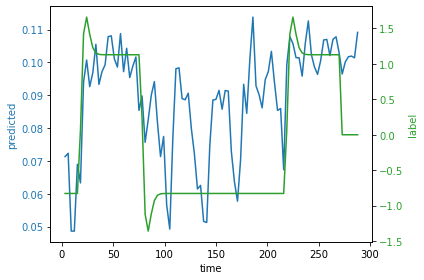

torch.Size([1, 96])
torch.Size([1, 1, 96])


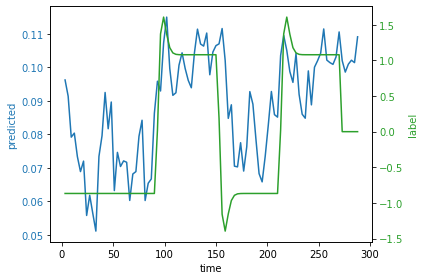

torch.Size([1, 96])
torch.Size([1, 1, 96])


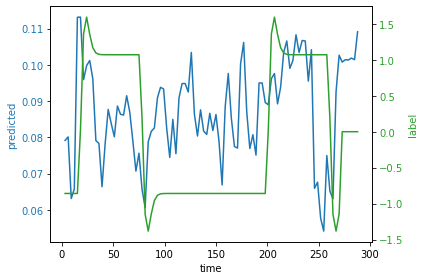

torch.Size([1, 96])
torch.Size([1, 1, 96])


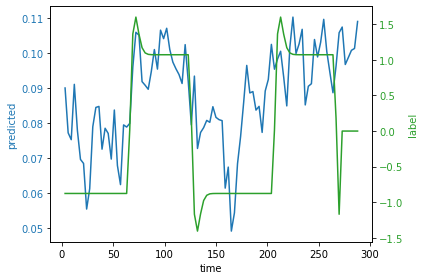

torch.Size([1, 96])
torch.Size([1, 1, 96])


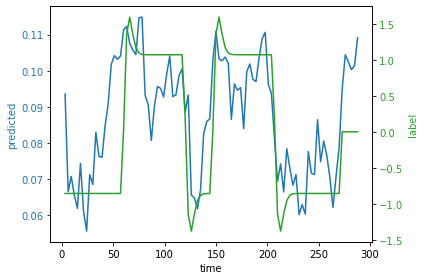

torch.Size([1, 96])
torch.Size([1, 1, 96])


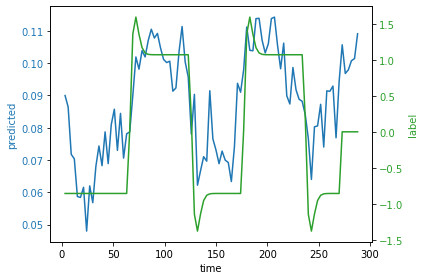

torch.Size([1, 96])
torch.Size([1, 1, 96])


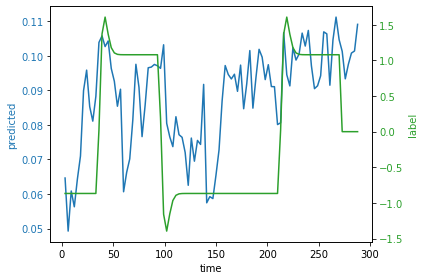

torch.Size([1, 96])
torch.Size([1, 1, 96])


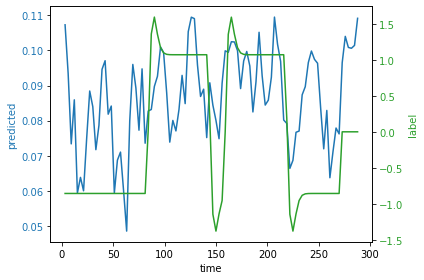

torch.Size([1, 96])
torch.Size([1, 1, 96])


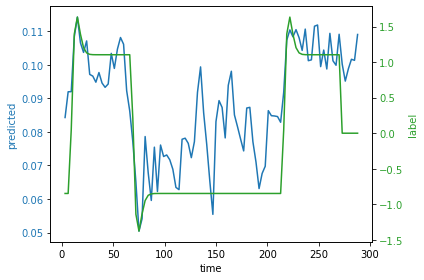

torch.Size([1, 96])
torch.Size([1, 1, 96])


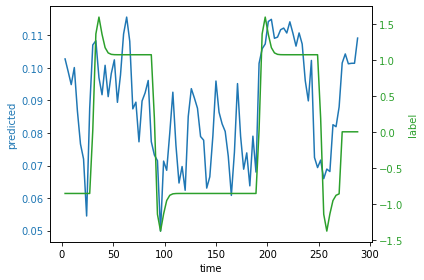

In [41]:
#가상데이터를 모델에 입력
#데이터는 torch.Size([1, 1, 160])이어야함
import matplotlib.pyplot as plt
import torch
model = UNet().to(device)
model.cpu()
time = np.linspace(3,288,96)
    
device = 6 if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    model.load_state_dict(torch.load('./UNet3.pth', map_location='cpu'))
    for i in range(10):

        fmri_one, label = test_set[i]
        print(fmri_one.shape)
        fmri_one = fmri_one.unsqueeze(0)
        print(fmri_one.shape)
        predicted = model(fmri_one)
        fmri_one = fmri_one.squeeze()
        predicted = predicted.squeeze()
        label = label.squeeze()
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('time')
        ax1.set_ylabel('predicted', color=color)
        ax1.plot(time, predicted, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # 두 번째 y축을 생성합니다.
        color = 'tab:green'
        ax2.set_ylabel('label', color=color)  
        ax2.plot(time, label, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()  
        plt.show()
